# Stochastic PDE model for natural gas network
(model from victor m. zavala / 2013, adapted from pyomo/examples/dae)

### 0. Introduction

> Consider a gas network with links comprising of long pipelines and nodes consisting of junction points and compressors. Gas is withdrawn from the network at a set of demand nodes and make-up gas is brought into the system through a set of supply nodes. In a real-time environment, the system operator must balance thenetwork to satisfy demand flows and delivery pressures at all times

![Fig. GasNetwork](./img/gas_ntwrk.png)

The main part of the model consists of the conservation and momentum equations at a pipe for a given link $l \in \mathcal{L}$ and scenario $\omega \in \Omega$ in a series of pdes. These are given in therms of the scaled pressures $p_{l}$ and mass flows $f_{l}$

\begin{align}
\dfrac{\partial \rho_{l}}{\partial \tau} + \dfrac{\rho_{l}\left(\tau, x, \omega \right)}{\partial x} &= 0 \\
\dfrac{\partial f_{l} \left(\tau, x, \omega\right)}{\partial \tau} + \dfrac{\partial p_{l}\left(\tau, x, \omega \right)}{\partial x} &= -\dfrac{\lambda_{l}}{2D_{l}}\rho_{l}\left(\tau, x, \omega \right) \nu_{l} \left(\tau, x, \omega \right) \left|\nu_{l} \left(\tau, x, \omega \right) \right|
\end{align}

\begin{align}
\dfrac{\partial p_{l}}{\partial \tau} &= - c_{1, l} \dfrac{\partial f_{l}\left(\tau, x, \omega \right)  }{\partial x} \\ 
& l \in \mathcal{L}, \tau \in \mathcal{T}, x \in X_{l}, \omega \in \Omega \\
\dfrac{\partial f_{l} \left(\tau, x, \omega\right)}{\partial \tau} &= -c_{2, l} \dfrac{p_{l}\left(\tau, x, \omega \right)}{\partial x}  - c_{3, l} \dfrac{f_{l}\left(\tau, x, \omega \right) \left| f_{l}\left(\tau, x, \omega \right) \right|  }{p_{l}\left(\tau, x, \omega\right)} \\
& l \in \mathcal{L}, \tau \in \mathcal{T}, x \in X_{l}, \omega \in \Omega \\
\end{align}

Moreover, the model is coupled with the mass balances at the nodes nodes $n \in \mathcal{N}$,

\begin{equation} 
\sum_{l \in \mathcal{L}^{in}_{n}} f^{in}_{l} \left(\tau, \omega \right) - \sum_{l \in \mathcal{L}^{out}_{n}} f^{out}_{l} \left(\tau, \omega\right) + \sum_{i \in \mathcal{J}} s_{i} \left(\tau, \omega \right) - \sum_{j \in \mathcal{j}_{n}} s_{i} \left(\tau, \omega \right) - \sum_{j \in \mathcal{D}_{n}} d_{j} \left(\tau, \omega \right) = 0, n \in \mathcal{N}, \tau \in \mathcal{J}, \omega \in \Omega
\end{equation}

And the set of boundary conditions:

\begin{equation}
f_{l} \left( \tau, L_{l}, \omega \right) = \theta_{rec} \left( \tau, \omega \right), l \in L, \tau \in T, \omega \in \Omega
\end{equation}

\begin{equation}
f_{l} \left(\tau, 0, \omega \right) = f ^{in}_{l} \left(\tau, \omega \right), l \in \mathcal{L}, \tau \in \mathcal{T}, \omega \in {\Omega}
\end{equation}

\begin{align}
p_{l} \left( \tau, L_{l}, \omega \right) &= \theta_{rec} \left(\tau, \omega \right), l \in \mathcal{L}, \tau \in \mathcal{T}, \omega \in \Omega \\
p_{l} \left( \tau, 0, \omega \right) &= \theta_{sndl} \left(\tau, \omega \right), l \in \mathcal{L}_{p}, \tau \in \mathcal{T}, \omega \in \Omega \\
p_{l} \left( \tau, 0, \omega \right) &= \theta_{sndl} \left(\tau, \omega \right) + \Delta \theta_{l} \left(\tau \right) , l \in \mathcal{L}_{p}, \tau \in \mathcal{T}, \omega \in \Omega \\
\end{align} 

### 1. Imports and parameter declaration

In [3]:
from pyomo.environ import *
from pyomo.dae import *
from pyomo.core.base.numvalue import value
import time
import sys

In [4]:
TF_ = 24.
TDEC_ = 9.5
S_ = 3
CVAR_LAMBDA_ = 0.
LINK_ = ["l1", "l2", "l3", "l4", "l5", "l6", "l7", "l8", "l9", "l10", "l11", "l12"]
LSTARTLOC_ = {
    "l1": "n1",
    "l2": "n2",
    "l3": "n3",
    "l4": "n4",
    "l5": "n5",
    "l6": "n6",
    "l7": "n7",
    "l8": "n8",
    "l9": "n9",
    "l10": "n10",
    "l11": "n11",
    "l12": "n12"}
LENDLOC_ = {
    "l1": "n2",
    "l2": "n3",
    "l3": "n4",
    "l4": "n5",
    "l5": "n6",
    "l6": "n7",
    "l7": "n8",
    "l8": "n9",
    "l9": "n10",
    "l10": "n11",
    "l11": "n12",
    "l12": "n13"}
LDIAM_ = dict().fromkeys(LINK_, 920.)
LLENGTH_ = dict().fromkeys(LINK_, 100.)
LLENGTH_["l1"] = 300.
LLENGTH_["l12"] = 300.
LTYPE_ = dict().fromkeys(LINK_, "a")
LTYPE_["l1"] = "p"
LTYPE_["l12"] = "p"

In [5]:
LINK_A_ = [i for i in LINK_ if LTYPE_[i] == "a"]
print(LINK_A_)
LINK_P_ = [i for i in LINK_ if LTYPE_[i] == "p"]
print(LINK_P_)

['l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10', 'l11']
['l1', 'l12']


In [6]:
NODE_ = ["n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9", "n10", "n11", "n12", "n13"]
PMIN_ = dict().fromkeys(NODE_, 34.)
PMIN_["n1"] = 57.
PMIN_["n13"] = 39.
PMAX_ = dict().fromkeys(NODE_, 70.)
PMAX_["n13"] = 41.
SUP_ = [1]  #: These guys define sets, therefore must be iterable
SLOC_ = "n1"
SMIN_ = 0.
SMAX_ = 30.
DEM_ = [1]  #: These guys define sets, therefore must be iterable
DLOC_ = "n13"
D_ = 10

### 2. Model and Sets

In [7]:
model = ConcreteModel()

In [8]:
model.time = ContinuousSet(initialize=(0.5, TF_))
model.dis = ContinuousSet(bounds=(0.0, 1.0))

In [9]:
model.link = Set(initialize=LINK_)
model.NODE = Set(initialize=NODE_, doc="set of nodes")
model.SUP = Set(initialize=SUP_, doc="set of supply")
model.DEM = Set(initialize=DEM_, doc="demand")
model.scen = RangeSet(1, S_, doc="scenarios")
model.LINK_A = Set(initialize=LINK_A_, doc="links of kind a")
model.LINK_P = Set(initialize=LINK_P_, doc="links of kind b")

### 3. Parameters

In [10]:
model.S = Param(within=PositiveIntegers, initialize=S_, doc="number of scenarios")

Links

In [11]:
model.lstartloc = Param(model.link, initialize=LSTARTLOC_)
model.lendloc = Param(model.link, initialize=LENDLOC_)
model.ldiam = Param(model.link, within=PositiveReals, mutable=True, default=LDIAM_)
model.llength = Param(model.link, within=PositiveReals, mutable=True, initialize=LLENGTH_)
model.ltype = Param(model.link, initialize=LTYPE_)

Nodes

In [12]:
model.pmin = Param(model.NODE, within=PositiveReals, mutable=True, initialize=PMIN_)
model.pmax = Param(model.NODE, within=PositiveReals, mutable=True, initialize=PMAX_)

Supply

In [13]:
model.sloc = Param(model.SUP, default=SLOC_)
model.smin = Param(model.SUP, within=NonNegativeReals, mutable=True, default=SMIN_)
model.smax = Param(model.SUP, within=NonNegativeReals, mutable=True, default=SMAX_)
model.scost = Param(model.SUP, within=NonNegativeReals)

Demand

In [14]:
model.dloc = Param(model.DEM, default=DLOC_)
model.d = Param(model.DEM, within=PositiveReals, mutable=True, default=D_)

 Physical data

In [15]:
model.eps = Param(initialize=0.025, within=PositiveReals)
model.z = Param(initialize=0.80, within=PositiveReals)
model.rhon = Param(initialize=0.72, within=PositiveReals)
model.R = Param(initialize=8314.0, within=PositiveReals)
model.M = Param(initialize=18.0, within=PositiveReals)
model.pi = Param(initialize=3.14, within=PositiveReals)
model.nu2 = Param(within=PositiveReals, mutable=True)
model.lam = Param(model.link, within=PositiveReals, mutable=True)
model.A = Param(model.link, within=NonNegativeReals, mutable=True)
model.Tgas = Param(initialize=293.15, within=PositiveReals)
model.Cp = Param(initialize=2.34, within=PositiveReals)
model.Cv = Param(initialize=1.85, within=PositiveReals)
model.gam = Param(initialize=model.Cp / model.Cv, within=PositiveReals)
model.om = Param(initialize=(model.gam - 1.0) / model.gam, within=PositiveReals)

Constraint scaling

In [16]:
model.ffac = Param(within=PositiveReals, initialize=(1.0e+6 * model.rhon) / (24.0 * 3600.0))
model.ffac2 = Param(within=PositiveReals, initialize=(3600.0) / (1.0e+4 * model.rhon))
model.pfac = Param(within=PositiveReals, initialize=1.0e+5)
model.pfac2 = Param(within=PositiveReals, initialize=1.0e-5)
model.dfac = Param(within=PositiveReals, initialize=1.0e-3)
model.lfac = Param(within=PositiveReals, initialize=1.0e+3)

In [17]:
model.c1 = Param(model.link, within=PositiveReals, mutable=True)
model.c2 = Param(model.link, within=PositiveReals, mutable=True)
model.c3 = Param(model.link, within=PositiveReals, mutable=True)
model.c4 = Param(within=PositiveReals, mutable=True)

Cost

In [18]:
model.ce = Param(initialize=0.1, within=NonNegativeReals)
model.cd = Param(initialize=1.0e+6, within=NonNegativeReals)
model.cT = Param(initialize=1.0e+6, within=NonNegativeReals)
model.cs = Param(initialize=0.0, within=NonNegativeReals)
model.TDEC = Param(within=PositiveReals, initialize=TDEC_)

Stochastic information

In [19]:
model.rand_d = Param(model.scen, model.DEM, within=NonNegativeReals, mutable=True)

#### Build actions
Build actions are a set of *recipes* that will be executed at the moment model is constructed.

In [20]:
# convert units for input data
def rescale_rule(m):
    for i in m.link:
        m.ldiam[i] = m.ldiam[i] * m.dfac
        m.llength[i] = m.llength[i] * m.lfac
        # m.dx[i] = m.llength[i]/float(m.dis.last())

    for i in m.SUP:
        m.smin[i] = m.smin[i] * m.ffac * m.ffac2  # from scmx106/day to kg/s and then to scmx10-4/hr
        m.smax[i] = m.smax[i] * m.ffac * m.ffac2  # from scmx106/day to kg/s and then to scmx10-4/hr

    for i in m.DEM:
        m.d[i] = m.d[i] * m.ffac * m.ffac2

    for i in m.NODE:
        m.pmin[i] = m.pmin[i] * m.pfac * m.pfac2  # from bar to Pascals and then to bar
        m.pmax[i] = m.pmax[i] * m.pfac * m.pfac2  # from bar to Pascals and then to bar


model.rescale = BuildAction(rule=rescale_rule)

In [21]:
def compute_constants(m):
    for i in m.link:
        m.lam[i] = (2.0 * log10(3.7 * m.ldiam[i] / (m.eps * m.dfac))) ** (-2.0)
        m.A[i] = (1.0 / 4.0) * m.pi * m.ldiam[i] * m.ldiam[i]
        m.nu2 = m.gam * m.z * m.R * m.Tgas / m.M
        m.c1[i] = (m.pfac2 / m.ffac2) * (m.nu2 / m.A[i])
        m.c2[i] = m.A[i] * (m.ffac2 / m.pfac2)
        m.c3[i] = m.A[i] * (m.pfac2 / m.ffac2) * (8.0 * m.lam[i] * m.nu2) / (m.pi * m.pi * (m.ldiam[i] ** 5.0))
        m.c4 = (1 / m.ffac2) * (m.Cp * m.Tgas)


model.compute_constants = BuildAction(rule=compute_constants)

In [22]:
# set stochastic demands
def compute_demands_rule(m):
    for k in m.scen:
        for j in m.DEM:
            if k == 2:
                m.rand_d[k, j] = 1.1 * m.d[j]
            elif k == 1:
                m.rand_d[k, j] = 1.2 * m.d[j]
            else:
                m.rand_d[k, j] = 1.3 * m.d[j]


model.compute_demands = BuildAction(rule=compute_demands_rule)

In [23]:
def stochd_init(m, k, j, t):
    # What it should be to match description in paper
    # if t < m.TDEC:
    #     return m.d[j]
    # if t >= m.TDEC and t < m.TDEC+5:
    #     return m.rand_d[k,j]
    # if t >= m.TDEC+5:
    #     return m.d[j]
    if t < m.TDEC + 1:
        return m.d[j]
    if t >= m.TDEC + 1 and t < m.TDEC + 1 + 4.5:
        return m.rand_d[k, j]
    if t >= m.TDEC + 1 + 4.5:
        return m.d[j]


model.stochd = Param(model.scen, model.DEM, model.time, within=PositiveReals, mutable=True, default=stochd_init)

### 4. Variables

In [24]:
# define temporal variables bounds rule
def p_bounds_rule(m, k, j, t):
    return (value(m.pmin[j]), value(m.pmax[j]))
def s_bounds_rule(m, k, j, t):
    return (0.01, value(m.smax[j]))

Single *ContinuousSet* variables.

In [25]:
model.p = Var(model.scen, model.NODE, model.time, bounds=p_bounds_rule, initialize=50.0)
model.dp = Var(model.scen, model.LINK_A, model.time, bounds=(0.0, 100.0), initialize=10.0)
model.fin = Var(model.scen, model.link, model.time, bounds=(1.0, 500.0), initialize=100.0)
model.fout = Var(model.scen, model.link, model.time, bounds=(1.0, 500.0), initialize=100.0)

In [26]:
model.s = Var(model.scen, model.SUP, model.time, bounds=s_bounds_rule, initialize=10.0)
model.dem = Var(model.scen, model.DEM, model.time, initialize=100.0)
model.pow = Var(model.scen, model.LINK_A, model.time, bounds=(0.0, 3000.0), initialize=1000.0)
model.slack = Var(model.scen, model.link, model.time, model.dis, bounds=(0.0, None), initialize=10.0)

Time-space *ContinuousSet* variables

In [27]:
model.px = Var(model.scen, model.link, model.time, model.dis, bounds=(10.0, 100.0), initialize=50.0)
model.fx = Var(model.scen, model.link, model.time, model.dis, bounds=(1.0, 100.0), initialize=100.0)

*DerivativeVars* (Given for the differential variables)

In [28]:
model.dpxdt = DerivativeVar(model.px, wrt=model.time, initialize=0)
model.dpxdx = DerivativeVar(model.px, wrt=model.dis, initialize=0)
model.dfxdt = DerivativeVar(model.fx, wrt=model.time, initialize=0)
model.dfxdx = DerivativeVar(model.fx, wrt=model.dis, initialize=0)

cvar model

In [29]:
model.cvar_lambda = Param(within=NonNegativeReals, initialize=CVAR_LAMBDA_)
model.nu = Var(initialize=100.0)
model.phi = Var(model.scen, bounds=(0.0, None), initialize=100.0)

### 5. Constraints

In [30]:
# compressor equations
def powereq_rule(m, j, i, t):
    return m.pow[j, i, t] == m.c4 * m.fin[j, i, t] * (
                ((m.p[j, m.lstartloc[i], t] + m.dp[j, i, t]) / m.p[j, m.lstartloc[i], t]) ** m.om - 1.0)



model.powereq = Constraint(model.scen, model.LINK_A, model.time, rule=powereq_rule)

def cvarcost_rule(m):
    return (1.0 / m.S) * sum((m.phi[k] / (1.0 - 0.95) + m.nu) for k in m.scen)


model.cvarcost = Expression(rule=cvarcost_rule)


# node balances
def nodeeq_rule(m, k, i, t):
    return sum(m.fout[k, j, t] for j in m.link if m.lendloc[j] == i) + \
           sum(m.s[k, j, t] for j in m.SUP if m.sloc[j] == i) - \
           sum(m.fin[k, j, t] for j in m.link if m.lstartloc[j] == i) - \
           sum(m.dem[k, j, t] for j in m.DEM if m.dloc[j] == i) == 0.0


model.nodeeq = Constraint(model.scen, model.NODE, model.time, rule=nodeeq_rule)


# boundary conditions flow
def flow_start_rule(m, j, i, t):
    return m.fx[j, i, t, m.dis.first()] == m.fin[j, i, t]


model.flow_start = Constraint(model.scen, model.link, model.time, rule=flow_start_rule)


def flow_end_rule(m, j, i, t):
    return m.fx[j, i, t, m.dis.last()] == m.fout[j, i, t]


model.flow_end = Constraint(model.scen, model.link, model.time, rule=flow_end_rule)


# First PDE for gas network model
def flow_rule(m, j, i, t, k):
    if t == m.time.first() or k == m.dis.last():
        return Constraint.Skip  # Do not apply pde at initial time or final location
    return m.dpxdt[j, i, t, k] / 3600 + m.c1[i] / m.llength[i] * m.dfxdx[j, i, t, k] == 0


model.flow = Constraint(model.scen, model.link, model.time, model.dis, rule=flow_rule)


# Second PDE for gas network model
def press_rule(m, j, i, t, k):
    if t == m.time.first() or k == m.dis.last():
        return Constraint.Skip  # Do not apply pde at initial time or final location
    return m.dfxdt[j, i, t, k] / 3600 == -m.c2[i] / m.llength[i] * m.dpxdx[j, i, t, k] - m.slack[j, i, t, k]


model.press = Constraint(model.scen, model.link, model.time, model.dis, rule=press_rule)


def slackeq_rule(m, j, i, t, k):
    if t == m.time.last():
        return Constraint.Skip
    return m.slack[j, i, t, k] * m.px[j, i, t, k] == m.c3[i] * m.fx[j, i, t, k] * m.fx[j, i, t, k]


model.slackeq = Constraint(model.scen, model.link, model.time, model.dis, rule=slackeq_rule)


# boundary conditions pressure, passive links
def presspas_start_rule(m, j, i, t):
    return m.px[j, i, t, m.dis.first()] == m.p[j, m.lstartloc[i], t]


model.presspas_start = Constraint(model.scen, model.LINK_P, model.time, rule=presspas_start_rule)


def presspas_end_rule(m, j, i, t):
    return m.px[j, i, t, m.dis.last()] == m.p[j, m.lendloc[i], t]


model.presspas_end = Constraint(model.scen, model.LINK_P, model.time, rule=presspas_end_rule)


# boundary conditions pressure, active links
def pressact_start_rule(m, j, i, t):
    return m.px[j, i, t, m.dis.first()] == m.p[j, m.lstartloc[i], t] + m.dp[j, i, t]


model.pressact_start = Constraint(model.scen, model.LINK_A, model.time, rule=pressact_start_rule)


def pressact_end_rule(m, j, i, t):
    return m.px[j, i, t, m.dis.last()] == m.p[j, m.lendloc[i], t]


model.pressact_end = Constraint(model.scen, model.LINK_A, model.time, rule=pressact_end_rule)


# fix pressure at supply nodes
def suppres_rule(m, k, j, t):
    return m.p[k, m.sloc[j], t] == m.pmin[m.sloc[j]]


model.suppres = Constraint(model.scen, model.SUP, model.time, rule=suppres_rule)


# discharge pressure for compressors
def dispress_rule(m, j, i, t):
    return m.p[j, m.lstartloc[i], t] + m.dp[j, i, t] <= m.pmax[m.lstartloc[i]]


model.dispress = Constraint(model.scen, model.LINK_A, model.time, rule=dispress_rule)


# ss constraints
def flow_ss_rule(m, j, i, k):
    if k == m.dis.last():
        return Constraint.Skip
    return m.dfxdx[j, i, m.time.first(), k] / m.llength[i] == 0.0


model.flow_ss = Constraint(model.scen, model.link, model.dis, rule=flow_ss_rule)


def pres_ss_rule(m, j, i, k):
    if k == m.dis.last():
        return Constraint.Skip
    return 0.0 == - m.c2[i] / m.llength[i] * m.dpxdx[j, i, m.time.first(), k] - m.slack[j, i, m.time.first(), k]


model.pres_ss = Constraint(model.scen, model.link, model.dis, rule=pres_ss_rule)


# non-anticipativity constraints
def nonantdq_rule(m, j, i, t):
    if j == 1:
        return Constraint.Skip
    if t >= m.TDEC + 1:
        return Constraint.Skip
    return m.dp[j, i, t] == m.dp[1, i, t]


model.nonantdq = Constraint(model.scen, model.LINK_A, model.time, rule=nonantdq_rule)


def nonantde_rule(m, j, i, t):
    if j == 1:
        return Constraint.Skip
    if t >= m.TDEC + 1:
        return Constraint.Skip
    return m.dem[j, i, t] == m.dem[1, i, t]


model.nonantde = Constraint(model.scen, model.DEM, model.time, rule=nonantde_rule)

In [31]:
# discretize model
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(model, nfe=1, wrt=model.dis, scheme='FORWARD')
discretizer.apply_to(model, nfe=47, wrt=model.time, scheme='BACKWARD')

In [32]:
# What it should be to match description in paper
# discretizer.apply_to(model,nfe=48,wrt=model.time,scheme='BACKWARD')

TimeStep = model.time[2] - model.time[1]


def supcost_rule(m, k):
    return sum(m.cs * m.s[k, j, t] * (TimeStep) for j in m.SUP for t in m.time.get_finite_elements())


model.supcost = Expression(model.scen, rule=supcost_rule)


def boostcost_rule(m, k):
    return sum(m.ce * m.pow[k, j, t] * (TimeStep) for j in m.LINK_A for t in m.time.get_finite_elements())


model.boostcost = Expression(model.scen, rule=boostcost_rule)


def trackcost_rule(m, k):
    return sum(m.cd * (m.dem[k, j, t] - m.stochd[k, j, t]) ** 2.0 for j in m.DEM for t in m.time.get_finite_elements())


model.trackcost = Expression(model.scen, rule=trackcost_rule)


def sspcost_rule(m, k):
    return sum(
        m.cT * (m.px[k, i, m.time.last(), j] - m.px[k, i, m.time.first(), j]) ** 2.0 for i in m.link for j in m.dis)


model.sspcost = Expression(model.scen, rule=sspcost_rule)


def ssfcost_rule(m, k):
    return sum(
        m.cT * (m.fx[k, i, m.time.last(), j] - m.fx[k, i, m.time.first(), j]) ** 2.0 for i in m.link for j in m.dis)


model.ssfcost = Expression(model.scen, rule=ssfcost_rule)


def cost_rule(m, k):
    return 1e-6 * (m.supcost[k] + m.boostcost[k] + m.trackcost[k] + m.sspcost[k] + m.ssfcost[k])


model.cost = Expression(model.scen, rule=cost_rule)


def mcost_rule(m):
    return (1.0 / m.S) * sum(m.cost[k] for k in m.scen)


model.mcost = Expression(rule=mcost_rule)


def eqcvar_rule(m, k):
    return m.cost[k] - m.nu <= m.phi[k]


model.eqcvar = Constraint(model.scen, rule=eqcvar_rule)

The objective function is a weighted sum of expected value and the conditional-value-at ristk (CVar) as follows:
\begin{equation}
\psi = \left( 1 - \xi \right) \mathbb{E} \left[\varphi (\omega)  \right] + \xi \text{CVaR} \left[\varphi (\omega) \right]
\end{equation}
Where the CVar is,
\begin{equation}
\text{CVar} \left[\varphi (\omega) \right] = \min_{\nu} \left[\nu + \dfrac{1}{1 - \sigma} \mathbb{E} \left(\varphi (\omega)  - \nu \right) \right]
\end{equation} 

In [32]:
def obj_rule(m):
    return (1.0 - m.cvar_lambda) * m.mcost + m.cvar_lambda * m.cvarcost


model.obj = Objective(rule=obj_rule)

### 6. Solution

In [33]:
for i in model.scen:
    print("Scenario %s = %s" % (
        i, sum(sum(0.5 * value(model.pow[i, j, k])
                   for j in model.LINK_A)
               for k in model.time.get_finite_elements())))

Scenario 1 = 240000.0
Scenario 2 = 240000.0
Scenario 3 = 240000.0


In [34]:
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)

for i in model.scen:
    print("Scenario %s = %s" % (
        i, sum(sum(0.5 * value(model.pow[i, j, k])
                   for j in model.LINK_A)
               for k in model.time.get_finite_elements())))

/tmp/tmp1gh7dw8z.pyomo.nl -AMPL 
Ipopt vanilla0: 
This is Ipopt version vanilla0, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    75184
Number of nonzeros in inequality constraint Jacobian.:     4758
Number of nonzeros in Lagrangian Hessian.............:    14472

Total number of variables............................:    29056
                     variables with only lower bounds:     3423
                variables with lower and upper bounds:    15264
                     variables with only upper bounds:        0
Total number of equality constraints.................:    27872
Total number of inequality constraints...............:     1443
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1443

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5531252e+05 1.59e+05 3.89

Text(0.5, 0, 'Time t')

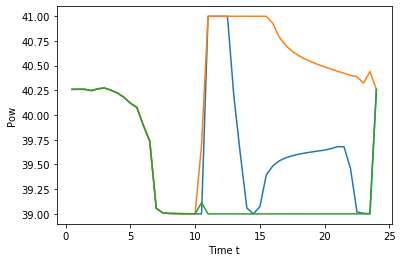

In [70]:
x = []
t = []
p = []
import matplotlib.pyplot as plt
fig = plt.figure()
for i in sorted(model.scen):
    temp = []
    tempx = []
    for j in sorted(model.time):
        tempx.append(j)
        temp.append(value(model.p[i, "n13", j]))
    x.append(tempx)
    # t.append(sorted(model.time))
    p.append(temp)
    plt.plot(tempx, temp)
plt.ylabel('Pow')
plt.xlabel('Time t')
